# Titanic - Machine Learning from Disaster

Developed by [André Moreira](https://github.com/moreira-and)

Based on the CRISP-DM (Cross-Industry Standard Process for Data Mining) methodology

Each subtopic will discuss a step of this methodology.

## 1. Entendimento do Negócio (Business Understanding)

The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## 2. Entendimento dos Dados (Data Understanding)
| Variable  | Definition                                     | Key                               |
|-----------|------------------------------------------------|-----------------------------------|
| survival  | Survival                                       | 0 = No, 1 = Yes                   |
| pclass    | Ticket class                                   | 1 = 1st, 2 = 2nd, 3 = 3rd         |
| sex       | Sex                                            |                                   |
| Age       | Age in years                                   |                                   |
| sibsp     | # of siblings / spouses aboard the Titanic     |                                   |
| parch     | # of parents / children aboard the Titanic     |                                   |
| ticket    | Ticket number                                  |                                   |
| fare      | Passenger fare                                 |                                   |
| cabin     | Cabin number                                   |                                   |
| embarked  | Port of Embarkation                            | C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes:
- **pclass**: A proxy for socio-economic status (SES)  
  - 1st = Upper  
  - 2nd = Middle  
  - 3rd = Lower

- **age**: Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5

- **sibsp**: The dataset defines family relations in this way...  
  - Sibling = brother, sister, stepbrother, stepsister  
  - Spouse = husband, wife (mistresses and fiancés were ignored)

- **parch**: The dataset defines family relations in this way...  
  - Parent = mother, father  
  - Child = daughter, son, stepdaughter, stepson  
  - Some children traveled only with a nanny, therefore `parch=0` for them.

## 3. Preparação dos Dados (Data Preparation)

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

### Read data

In [2]:
df_train = pd.read_csv('../data/raw/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# This data will be used to test the model. It is important: DO NOT TRAIN WITH THIS DATA!
df_test_in = pd.read_csv('../data/raw/test.csv')
df_test_in.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# This data will be used to test the model. It is important: DO NOT TRAIN WITH THIS DATA!
df_test_out = pd.read_csv('../data/raw/gender_submission.csv')
df_test_out.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### EDA

#### Cleaning

In [5]:
# Display DataFrame information
df_train.info()

# Look, we have columns with missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Find NA values
na_values = df_train.isna().sum()

# Identify columns with missing values
missing_columns = na_values[na_values > 0]
print("\n\nColumns with missing values:\n", missing_columns)

# Look, Cabin, Age, and Embarked have missing values; we need to work on these.
# Next steps could include:
# - Filling missing values
# - Dropping rows/columns
# - Imputing values based on other data, such as the mean or median.





Columns with missing values:
 Age         177
Cabin       687
Embarked      2
dtype: int64


In [7]:
df_train.head()
# Ok, let's take a look at the data. We will suppose some hypotheses:
# - Name and Ticket aren't important for causal effects and can be removed.
# PassengerId, Survived, Pclass, Cabin, and Embarked are categorical variables.
# - Cabin can be composed of a Embarkation.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# - Name aren't important for causal effects and can be removed.
# Drop the 'Name' column from the DataFrame
df_train.drop(columns=['Name','Ticket'], inplace=True)

In [9]:
# PassengerId, Survived, Pclass, Cabin, Sex and Embarked are categorical variables.
# Convert specified columns to categorical data type
df_train['PassengerId'] = df_train['PassengerId'].astype('category')
df_train['Survived'] = df_train['Survived'].astype('category')
df_train['Pclass'] = df_train['Pclass'].astype('category')
df_train['Cabin'] = df_train['Cabin'].astype('category')
df_train['Embarked'] = df_train['Embarked'].astype('category')
df_train['Sex'] = df_train['Sex'].astype('category')

In [10]:
# Display descriptive statistics of the remaining columns
df_train.describe()


,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [16]:
# - Cabin can be composed of a ticket and Embarkation.
tabela_contingencia = pd.crosstab(df_train['Pclass'],df_train['Cabin'])
tabela_contingencia

Cabin,A10,A14,A16,A19,A20,A23,A24,A26,A31,A32,...,E8,F E69,F G63,F G73,F2,F33,F38,F4,G6,T
Pclass,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,2,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,3,0,2,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,2,0,0,1,0,4,0


In [19]:
# If we separe the letter and number, this pass a context?
df_train[['Cabin_l','Cabin_n']] = df_train['Cabin'].str.extract(r'([A-Za-z]+)(\d+)')
df_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Cabin_l,Cabin_n
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,NaN,NaN
1,2,1,1,female,38.0,1,0,71.2833,C85,C,C,85
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,NaN,NaN
3,4,1,1,female,35.0,1,0,53.1000,C123,S,C,123
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,NaN,S,NaN,NaN
887,888,1,1,female,19.0,0,0,30.0000,B42,S,B,42
888,889,0,3,female,NaN,1,2,23.4500,NaN,S,NaN,NaN
889,890,1,1,male,26.0,0,0,30.0000,C148,C,C,148


In [21]:
# - Cabin can be composed of a ticket and Embarkation.
tabela_contingencia_l = pd.crosstab(df_train['Pclass'],df_train['Cabin_l'])
tabela_contingencia_l
# We have only Pclass 1 in this df

Cabin_l,A,B,C,D,E,F,G
Pclass,,,,,,,
1,15,47,59,29,25,0,0
2,0,0,0,1,4,8,0
3,0,0,0,0,4,1,7


In [24]:
# - Cabin can be composed of a ticket and Embarkation.
tabela_contingencia_n = pd.crosstab(df_train['Survived'],df_train['Cabin_l'])
tabela_contingencia_n

Cabin_l,A,B,C,D,E,F,G
Survived,,,,,,,
0,8,12,24,7,8,2,5
1,7,35,35,23,25,7,2


In [45]:
# - Cabin can be composed of a ticket and Embarkation.
tabela_contingencia_n = pd.crosstab(df_train['Cabin_n'],df_train['Survived']).reset_index()
tabela_contingencia_n

Survived,Cabin_n,0,1
0,10,1,2
1,101,0,5
2,102,1,0
3,103,0,1
4,104,0,1
...,...,...,...
87,93,0,2
88,94,1,0
89,95,1,0
90,96,0,4


TypeError: 'int' object is not subscriptable

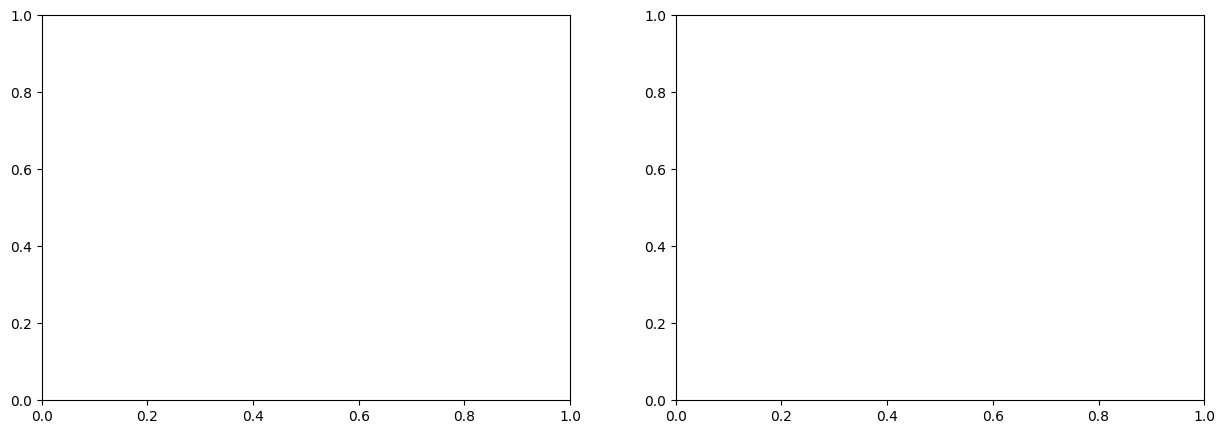

In [46]:
# List of columns to analyze
columns = [0, 1]

# Create subplots for boxplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.histplot(data=tabela_contingencia_n, x=column[0], ax=ax[0],kde=True)

plt.tight_layout()
plt.show()

#### Distribuction analisis

In [34]:
# Function to count outliers using the IQR method
def count_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers.shape[0]

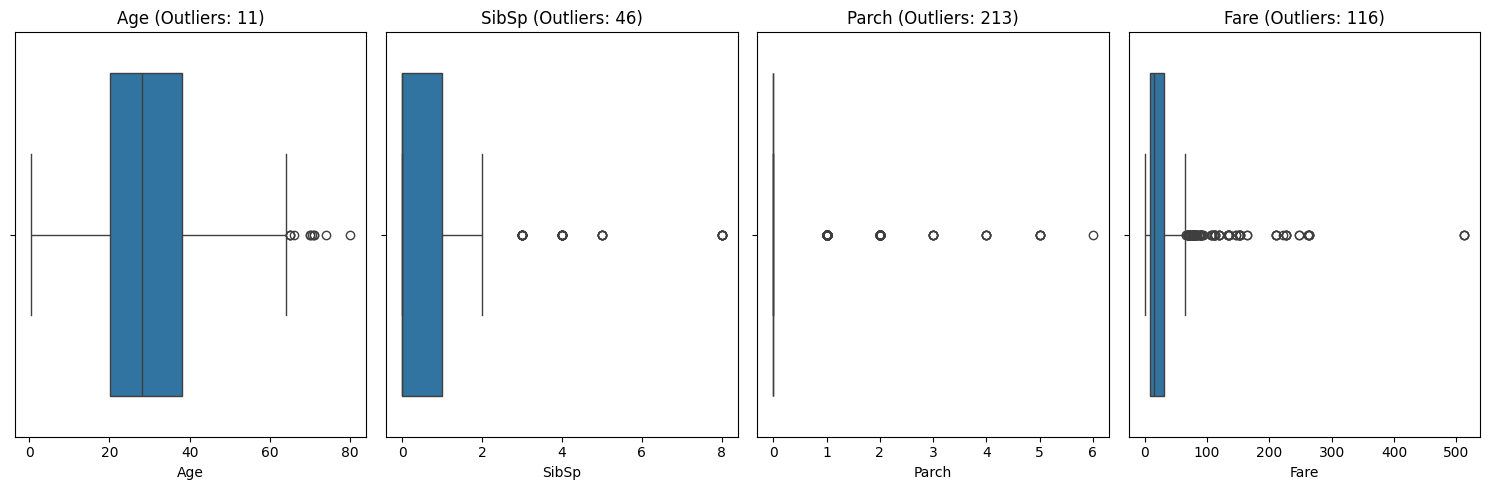

In [27]:
# List of columns to analyze
columns = ['Age', 'SibSp', 'Parch', 'Fare']

# Create subplots for boxplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Loop through each column and create boxplots and count outliers
for ax, column in zip(axes, columns):
    sns.boxplot(data=df_train, x=column, ax=ax)
    outlier_count = count_outliers(df_train, column)
    ax.set_title(f'{column} (Outliers: {outlier_count})')

plt.tight_layout()
plt.show()

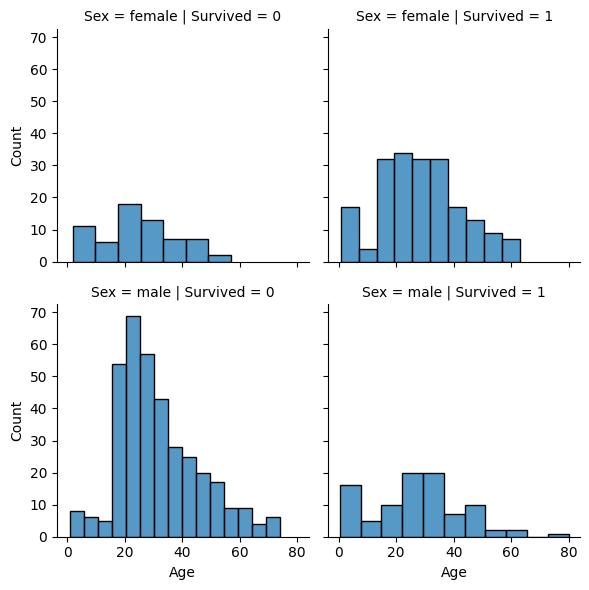

In [28]:
g = sns.FacetGrid(df_train, col="Survived",  row="Sex")
g.map_dataframe(sns.histplot, x="Age")

## 4. Modelagem (Modeling)

## 5. Avaliação (Evaluation)

## 6. Implementação (Deployment)